In [45]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Decay functions

In [46]:
def exponential_decay(start, end, t):
    return start * (end / start) ** t
    
def linear_decay(start, end, t):
    return start + (end - start) * t    

# Q-Learning

In [47]:
def q_learning(env, num_episodes=1000, lr_start=0.1, lr_end=0.5, eps_start=0.5, eps_end=0.0, gamma=0.999):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Q-Learning"):
        state = env.reset()
        total_reward = 0
        done = False

        t = episode / num_episodes
        epsilon = exponential_decay(eps_start, eps_end, t)
        learning_rate = linear_decay(lr_start, lr_end, t)

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            next_state, reward, done, _ = env.step(action)

            Q[state, action] += learning_rate * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    return rewards

# CEM

In [48]:
def cross_entropy(env, num_episodes=1000, elite_frac=0.7, num_samples=1000, learning_rate=0.5, goal = 7.8):
    num_actions = env.action_space.n
    state_dim = env.observation_space.n
    elite_num = int(num_samples * elite_frac)

    model = np.full((state_dim, num_actions), 1 / num_actions)

    def generate_episode():
        states, actions, rewards = [], [], []
        state = env.reset()
        done = False
        while not done:
            action_probs = model[state]
            sum_probs = action_probs.sum()
            if sum_probs > 0:
                action_probs /= sum_probs
            else:
                action_probs = np.full(num_actions, 1 / num_actions)
            action = np.random.choice(np.arange(num_actions), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
        return states, actions, rewards

    mean_rewards_history = []

    pbar = tqdm(range(num_episodes), desc="Cross-entropy")
    for _ in pbar:
        episodes = [generate_episode() for _ in range(num_samples)]
        episodes.sort(key=lambda ep: sum(ep[2]), reverse=True)
        elite_episodes = episodes[:elite_num]

        new_model = np.zeros_like(model)
        for states, actions, _ in elite_episodes:
            for state, action in zip(states, actions):
                new_model[state, action] += 1

        row_sums = new_model.sum(axis=1, keepdims=True)
        valid_rows = row_sums[:, 0] > 0
        new_model[valid_rows] /= row_sums[valid_rows] + (row_sums[valid_rows] == 0)
        model = model * (1 - learning_rate) + new_model * learning_rate

        total_reward = sum(sum(ep[2]) for ep in episodes) / num_samples
        pbar.set_postfix({"mtr":total_reward})
        mean_rewards_history.append(total_reward)
        if len(mean_rewards_history)>5 and np.mean(mean_rewards_history[-5:]) >= goal:
            print("Converged!")
            break
            
    return mean_rewards_history + [mean_rewards_history[-1]] * (num_episodes - len(mean_rewards_history))

# Monte-Carlo with epsilon-greedy policy

In [49]:
def monte_carlo(env, num_episodes=1000, eps_start=1.0, eps_end=0.1, gamma=0.99999):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))
    total_rewards_per_episode = []

    for episode in tqdm(range(num_episodes), desc="Monte Carlo"):
        t = episode / num_episodes
        epsilon = exponential_decay(eps_start, eps_end, t)
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qfunction[state])

            next_state, reward, done, _ = env.step(action)

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            total_reward += reward
            state = next_state

        total_rewards_per_episode.append(total_reward)

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards_per_episode

# SARSA with epsilon-greedy policy

In [50]:
def sarsa(env, num_episodes=1000, lr_start=0.1, lr_end=0.5, eps_start=0.5, eps_end=0.0, gamma=0.999):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Sarsa"):
        state = env.reset()
        total_reward = 0
        done = False

        t = episode / num_episodes
        epsilon = exponential_decay(eps_start, eps_end, t)
        learning_rate = linear_decay(lr_start, lr_end, t)

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            next_state, reward, done, _ = env.step(action)

            if np.random.rand() < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q[next_state, :])

            Q[state, action] += learning_rate * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    return rewards

# Setup

In [51]:
env = gym.make('Taxi-v3')
num_episodes = 10000

# Training

In [52]:
cross_entropy_rewards = cross_entropy(env, num_episodes=num_episodes)

Cross-entropy:   0%|          | 0/10000 [00:00<?, ?it/s]

Converged!


In [53]:
q_learning_rewards = q_learning(env, num_episodes=num_episodes)

Q-Learning:   0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
monte_carlo_rewards = monte_carlo(env, num_episodes=num_episodes)

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
sarsa_rewards = sarsa(env, num_episodes=num_episodes)

Sarsa:   0%|          | 0/10000 [00:00<?, ?it/s]

# Result plots

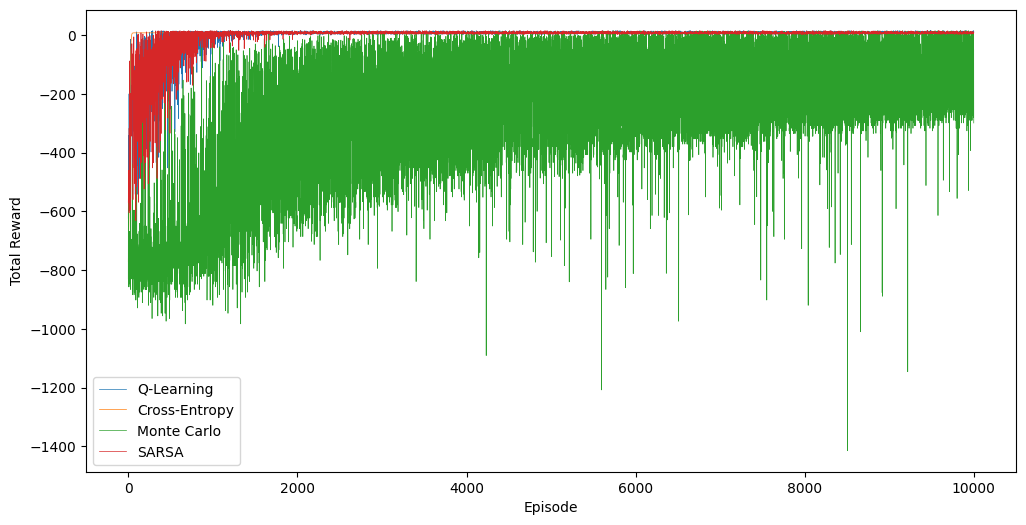

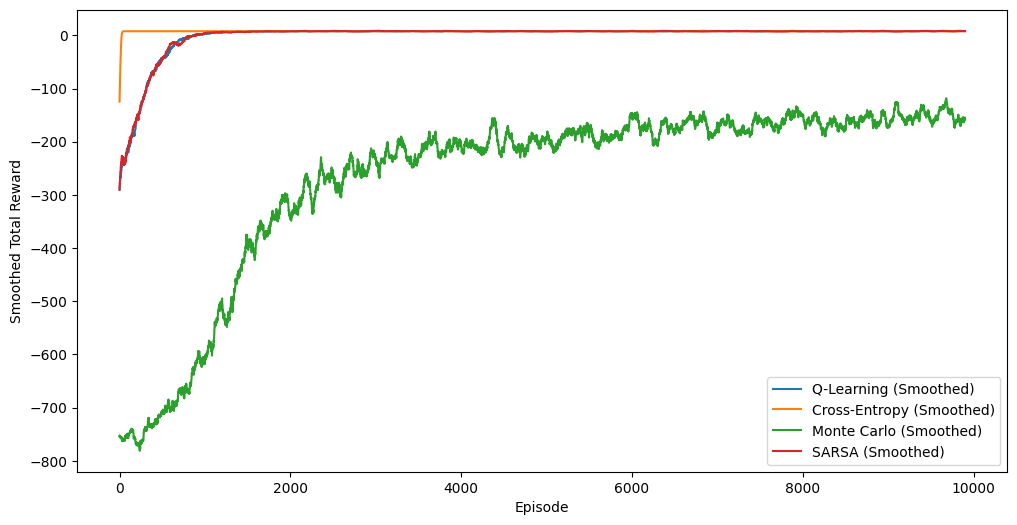

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(q_learning_rewards, label='Q-Learning', linewidth=0.5)
plt.plot(cross_entropy_rewards, label='Cross-Entropy', linewidth=0.5)
plt.plot(monte_carlo_rewards, label='Monte Carlo', linewidth=0.5)
plt.plot(sarsa_rewards, label='SARSA', linewidth=0.5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

window_size = 100

plt.figure(figsize=(12, 6))

smoothed_q_learning_rewards = np.convolve(q_learning_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_cross_entropy_rewards = np.convolve(cross_entropy_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_monte_carlo_rewards = np.convolve(monte_carlo_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sarsa_rewards = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(smoothed_q_learning_rewards, label='Q-Learning (Smoothed)', linewidth=1.5)
plt.plot(smoothed_cross_entropy_rewards, label='Cross-Entropy (Smoothed)', linewidth=1.5)
plt.plot(smoothed_monte_carlo_rewards, label='Monte Carlo (Smoothed)', linewidth=1.5)
plt.plot(smoothed_sarsa_rewards, label='SARSA (Smoothed)', linewidth=1.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.legend()
plt.show()

# Analyzis

Monte Carlo didn't converge.
SARSA and Q-Learning took approximately 1800 trajectories to converge.
Cross-entropy took approximately 97 * 1000 = 97000 trajectories to be processed before it converged.

# Conclusion
Even though it looks like cross-entropy converges faster in terms of episode count, the amount of trajectories it takes to generate is almost 10 times more, that SARSA and Q-Learning. Monte-Carlo did not perform well on this environment.